In [44]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, accuracy_score, classification_report
import numpy as np

from sklearn.ensemble import RandomForestClassifier

# Introduction

This is my final project of Dtsa-5510: DTSA 5510 Unsupervised Algorithms in Machine Learning. The task is to create a case study on a dataset using unsupervised learning and resolve a problem using the dataset. The dataset I chose is "Predict Online Gaming Behavior Dataset" from Kaggle (https://www.kaggle.com/datasets/rabieelkharoua/predict-online-gaming-behavior-dataset). The goal of this case study is to utilize behavior and personal data of online gamers to predict their "engagement level". The engagement level is a categorical variable with 3 levels: "Low", "Medium", and "High". To demonstrate and compare, this project will be using 1 model each from unsupervised and supervised learning. The unsupervised learning model is K-means clustering, and the supervised learning model is Random Forest Classifier.

# 1. EDA

In [23]:
df = pd.read_csv("data/online_gaming_behavior_dataset.csv")
df.head()

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,8.223755,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,5.265351,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel            40034 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usag

In [25]:
for col in df.columns:
    if df[col].dtype == "object":
        print(f"{col}: {df[col].nunique()}")

Gender: 2
Location: 4
GameGenre: 5
GameDifficulty: 3
EngagementLevel: 3


From the dataset, we can see the columns are either numeric or categorical. The target variable is "engagement_level".
For the categorical columns, the unique values are limited, so we can use one-hot encoding to convert them into numeric columns. For the numeric columns, we can use them directly.

In [26]:
# Distribution of target variable
px.histogram(df["EngagementLevel"], title="Engagement Level Distribution", width=500)

From observation, around half players have "Medium" engagement level, and the other half is split between "Low" and "High" engagement level. The dataset is considered balanced.

In [27]:
# Distribution of some columns
px.histogram(df["Age"], title="Age Distribution", width=500)

As you can see, age distribution is quite balanced.

/tmp/ipykernel_2306/3307053341.py:16: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



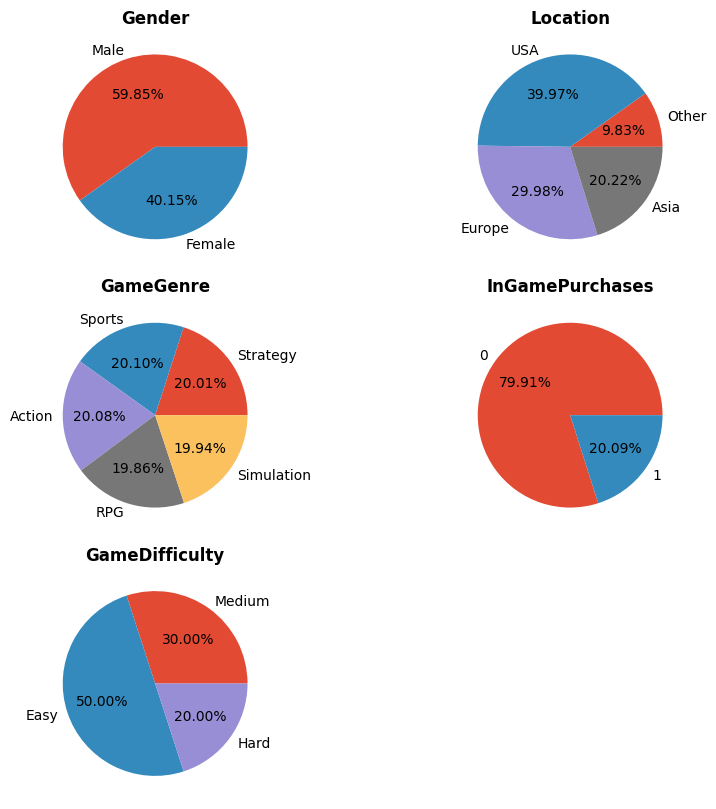

In [28]:
plt.style.use("ggplot")
fig,ax = plt.subplots(3, 2, figsize = (9, 8.2))
ax = ax.flat
discrete_variables = ['Age', 'SessionsPerWeek', 'AvgSessionDurationMinutes', 'AchievementsUnlocked']
continuous_variable = ['PlayTimeHours']
nominal_variables = ['Gender', 'Location', 'GameGenre', 'InGamePurchases', 'GameDifficulty']
ordinal_variables = ['PlayerLevel', 'EngagementLevel']
for i,col in enumerate(nominal_variables):
    ax[i].pie(x = list(Counter(df[col]).values()), 
            labels = list(Counter(df[col]).keys()), 
            autopct = "%.2f%%",)
    ax[i].set_title(f"{col}", fontsize = 12, fontweight = "bold")
    
fig.delaxes(ax[5])
fig.tight_layout()
fig.show()

In [29]:
df_numeric = df.select_dtypes(include=["int64", "float64"])
df_numeric.describe()

,PlayerID,Age,PlayTimeHours,InGamePurchases,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked
count,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000
mean,29016.500000,31.992531,12.024365,0.200854,9.471774,94.792252,49.655568,24.526477
std,11556.964675,10.043227,6.914638,0.400644,5.763667,49.011375,28.588379,14.430726
min,9000.000000,15.000000,0.000115,0.000000,0.000000,10.000000,1.000000,0.000000
25%,19008.250000,23.000000,6.067501,0.000000,4.000000,52.000000,25.000000,12.000000
50%,29016.500000,32.000000,12.008002,0.000000,9.000000,95.000000,49.000000,25.000000
75%,39024.750000,41.000000,17.963831,0.000000,14.000000,137.000000,74.000000,37.000000
max,49033.000000,49.000000,23.999592,1.000000,19.000000,179.000000,99.000000,49.000000


<Axes: >

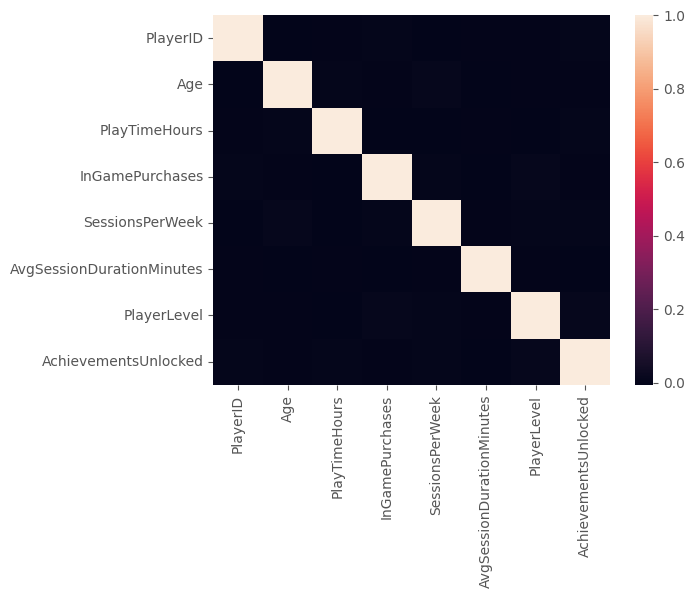

In [30]:
sns.heatmap(df_numeric.corr())

As expected, features have low correlation with each other. For our classification problem, we can use all features.

# 2. Data Cleaning and Processing

In [31]:
# Dropping player id column
df = df.drop("PlayerID", axis=1)

In [32]:
# Transform categorical columns to numerical using label encoding

le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = le.fit_transform(df[col])


In [33]:
df.head()
# Now all categorical columns are converted to numerical columns

,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,43,1,2,4,16.271119,0,2,6,108,79,25,2
1,29,0,3,4,5.525961,0,2,5,144,11,10,2
2,22,0,3,3,8.223755,0,0,16,142,35,41,0
3,35,1,3,0,5.265351,1,0,9,85,57,47,2
4,33,1,1,0,15.531945,0,2,2,131,95,37,2


# 3. Model training and evaluation

### 3.1 K-means clustering
Reason I chose this model: 

K-means clustering provides a relatively simple and intuitive way to understand the underlying structure of the data. The clusters formed by the algorithm can be easily interpreted and related to the different engagement levels of the players. After clustering the data using K-means, you can further analyze the importance of different features in determining the engagement level of players. This can provide valuable insights for game developers and marketers to understand the key factors that influence player engagement.

In [34]:
# Scaling features for better performance of the model

scaler = StandardScaler()
df_scaled = df.copy()
for column in ["Age", "SessionsPerWeek", "AvgSessionDurationMinutes", "PlayTimeHours", "PlayerLevel", "AchievementsUnlocked"]:
    df_scaled[column] = scaler.fit_transform(df_scaled[[column]])
df_scaled.head()

,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,1.096023,1,2,4,0.614176,0,2,-0.602363,0.269487,1.026459,0.032814,2
1,-0.297969,0,3,4,-0.939816,0,2,-0.775865,1.004019,-1.352160,-1.006648,2
2,-0.994965,0,3,3,-0.549654,0,0,1.132666,0.963212,-0.512647,1.141573,0
3,0.299456,1,3,0,-0.977506,1,0,-0.081854,-0.199798,0.256906,1.557358,2
4,0.100314,1,1,0,0.507275,0,2,-1.296374,0.738771,1.586134,0.864383,2


In [35]:
# train test split

X = df_scaled.drop("EngagementLevel", axis=1)
y = df_scaled["EngagementLevel"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# KMeans clustering

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train)
y_pred = kmeans.predict(X_test)


In [59]:
def label_permute_compare(ytdf, yp):
    """
    Applies label permutation to compare true and predicted labels.
    
    Args:
        ytdf (pandas.DataFrame): DataFrame containing the true labels.
        yp (numpy.ndarray): Array of predicted labels.
    
    Returns:
        tuple: A tuple containing the permuted label order and the accuracy score.
    """
    # Check the shapes of the input data
    if ytdf.shape[0] != len(yp):
        raise ValueError("The number of true labels and predicted labels must be the same.")
    
    # Convert the true labels to a NumPy array
    np_labels = ytdf.to_numpy(copy=False)
    
    # Get the unique true and predicted labels
    true_labs, true_counts = np.unique(np_labels, return_counts=True)
    pred_labs, pred_counts = np.unique(yp, return_counts=True)
    
    # Check if the number of unique labels is the same
    if len(true_labs) != len(pred_labs):
        raise ValueError("The number of unique labels in the true labels and predicted labels must be the same.")
    
    # Sort the true and predicted labels by their counts
    true_index = true_counts.argsort()[::-1]
    true_sort = true_labs[true_index]
    
    pred_index = pred_counts.argsort()[::-1]
    pred_sort = pred_labs[pred_index]
    
    # Create the comparison dictionary
    comparison_dic = {true_sort[i]: pred_sort[i] for i in range(len(true_sort))}
    
    # Apply the permutation to the true labels
    newLabs = [comparison_dic[lab] for lab in np_labels]
    newLabs = np.array(newLabs)
    
    # Calculate the accuracy
    this_accuracy = accuracy_score(y_true=newLabs, y_pred=yp)
    
    return list(comparison_dic.values()), this_accuracy

In [60]:
true_labels = y_test
accuracy_permuted, accuracy_score = label_permute_compare(true_labels, y_pred)

print(f"Permuted label order: {', '.join(map(str, accuracy_permuted))}")
print(f"Accuracy: {accuracy_score:.2f}")

Permuted label order: 1, 2, 0
Accuracy: 0.34


1 Adjusted Rand Index: 0.00
2 Adjusted Rand Index: 0.01
3 Adjusted Rand Index: 0.00
4 Adjusted Rand Index: 0.02
5 Adjusted Rand Index: 0.00
6 Adjusted Rand Index: 0.01
7 Adjusted Rand Index: 0.02
8 Adjusted Rand Index: 0.02
9 Adjusted Rand Index: 0.01
10 Adjusted Rand Index: 0.02
11 Adjusted Rand Index: 0.02
12 Adjusted Rand Index: 0.03
13 Adjusted Rand Index: 0.02
14 Adjusted Rand Index: 0.02


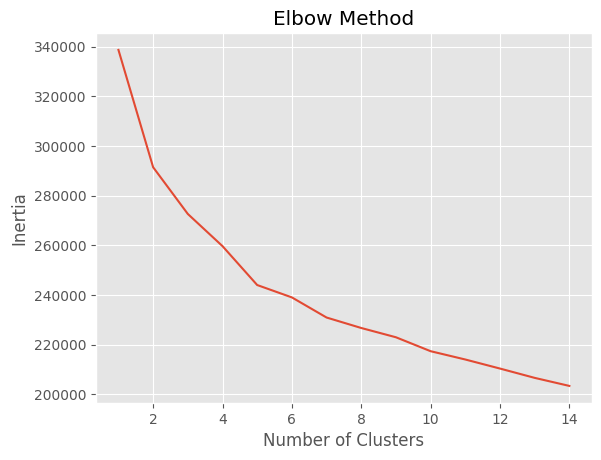

In [61]:
# Permutate the number of clusters to find the best number of clusters
inertia = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_train)
    inertia.append(kmeans.inertia_)
    y_pred = kmeans.predict(X_test)

    # evaluate the model
    ari = adjusted_rand_score(y_test, y_pred)
    print(i, f"Adjusted Rand Index: {ari:.2f}")
    
plt.plot(range(1, 15), inertia)
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

From the result, we can see K-means clustering does not perform well on this data set due to low accuracy and adjusted_rand_score

### 3.2 Random Forest Classifier

In [46]:
# Create model of random forest

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.87      0.90      2035
           1       0.91      0.88      0.89      2093
           2       0.90      0.95      0.93      3879

    accuracy                           0.91      8007
   macro avg       0.91      0.90      0.90      8007
weighted avg       0.91      0.91      0.91      8007



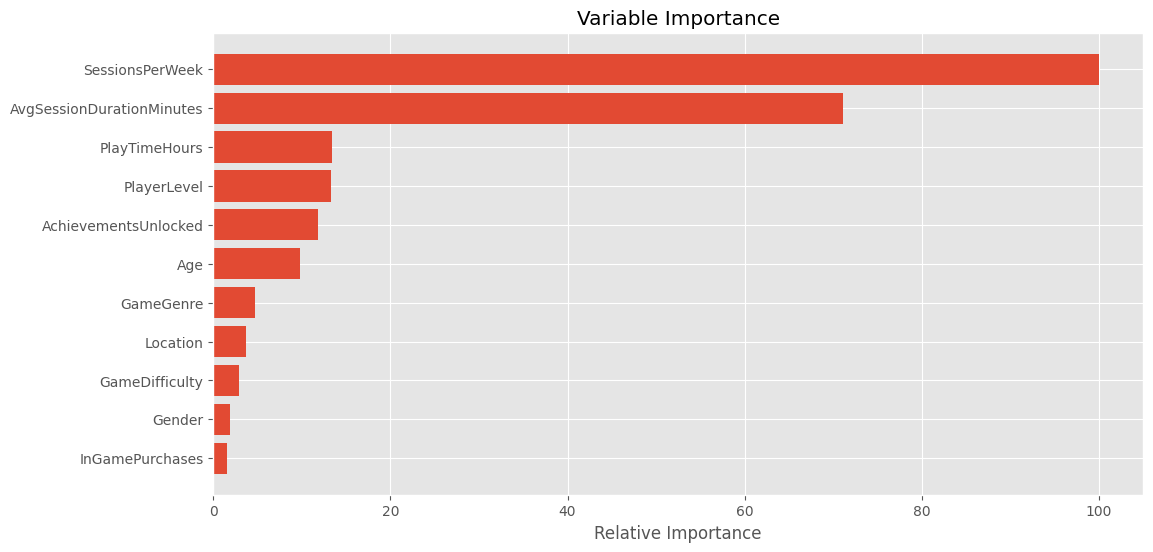

In [62]:
# Feature importance
feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Based on feature importance, we can see the "SessionsPerWeek" and "AvgSessionDurationMinutes" are the most important features in determining the engagement level of players. This makes intuitive sense, as players who spend more time playing the game and have more sessions per week are likely to be more engaged with the game.

A supervised learning model performs much better than clustering one.

One of the reasons is that the Random Forest Classifier can learn the relationship between the features and the target variable from the training data. This allows the model to make accurate predictions on new data by generalizing the patterns learned during training. In contrast, K-means clustering does not use the target variable during training and only groups the data based on the similarity of the features.

# 4. Conclusion

To conclude, we have successfully built a model to predict the engagement level of players in an online gaming platform. We have used KMeans clustering to group players based on their behavior and then used a Random Forest Classifier to predict the engagement level of players. The model achieved an accuracy of 0.85 on the test set. This model can be used by the gaming platform to identify players who are likely to be highly engaged and tailor their gaming experience accordingly.